# US Churn &mdash; Feature Engineering


## Setup

In [958]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown
plt.style.use("seaborn-darkgrid")
pd.set_option('display.max_columns', None)  

import sys, os, yaml

DATASET = "US_Churn"

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

DEBUG = False
SEED = 1612

C:\Users\ichig\AppData\Local\Temp\ipykernel_10396\208248166.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [959]:
if COLAB:
    from google.colab import drive
    if not os.path.isdir("/content/gdrive"):
        drive.mount("/content/gdrive")

## Imports

In [960]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

## Datasets

In [961]:
df = pd.read_pickle(f"{ROOT}/data/churn.pkl")
print(df.shape)
df.head()

(3333, 20)


,State,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,0,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,2,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,0,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [962]:
# drop feature that I have not yet considered properly in EDA
for c in ["State"]:
    if c in df.columns: df.drop(c, axis='columns', inplace=True)

## Pre-process Data

In [963]:
df_train, df_test = train_test_split(df, stratify=df.Churn, train_size=0.60, random_state=SEED)
df_train.shape, df_test.shape

((1999, 19), (1334, 19))

In [964]:
target = "Churn"
cat_features = [c for c in df.select_dtypes("category").columns if c not in target]
num_features = [c for c in df.select_dtypes(["int","float"]).columns if c not in target]
features = cat_features + num_features

print(f"Target: {target}")

print(f"Categorical Features: {cat_features}")
print(f"Numerical Features: {num_features}")
print(f"Number of Features: {len(features)}")

Target: Churn
Categorical Features: ['Area_Code', 'Intl_Plan', 'VMail_Plan']
Numerical Features: ['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']
Number of Features: 18


## Feature_Engineering 

Features engineering and selection decisions are carried out on `df_train` ONLY, but resulting operations should be applied to both `df_train` and `df_test`. The simplest way to do this (without repeating code) is to 

 * Perform querys on `df_train` to select new possible features.
 * Apply operations to `df` and repeat the train/test split USING THE SAME SEED.
 * You can use the target values in `df_train` but cannot use the target values in `df_test`.

### New Feature - Cranky Triskaidekaphobias

Would a feature indicating customers who complain and avoid the number 13 be useful in predicting Churn?

This is a silly feature, but illustrates the general procedure

In [965]:
my_query = df_train.query('CustServ_Calls>0 & Day_Calls!=13 & Eve_Calls!=13 & Night_Calls!=13 & Intl_Calls!=13')
my_query.head()

,Account_Length,Area_Code,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,Eve_Mins,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
519,41,2,0,0,0,202.9,97,34.49,153.8,104,13.07,113.5,92,5.11,9.0,3,2.43,3,0
2012,134,2,0,0,0,183.8,111,31.25,123.5,92,10.50,160.7,105,7.23,6.1,2,1.65,1,0
3120,96,0,0,1,21,247.6,95,42.09,256.3,150,21.79,158.6,72,7.14,10.8,6,2.92,2,0
2450,137,1,0,0,0,109.8,120,18.67,230.5,86,19.59,255.8,103,11.51,11.9,6,3.21,1,0
859,93,2,0,0,0,267.9,114,45.54,223.0,74,18.96,262.7,90,11.82,11.3,3,3.05,3,1


In [966]:
df["Cranky_Triskaidekaphobias"] = df.apply (lambda row: (row.CustServ_Calls>0
            and row.Day_Calls!=13 and row.Eve_Calls!=13
            and row.Night_Calls!=13 and row.Intl_Calls!=13), axis=1)

In [967]:
# Test generated feature to ensure has sufficient variability
df.Cranky_Triskaidekaphobias.value_counts()

True     2626
False     707
Name: Cranky_Triskaidekaphobias, dtype: int64

The feature increased the amount of features used and decreased the accuracy, hence it has been commmented out.

### New Feature - Average Time on Day Call
Does the amount of time a customer spends on each call, affect their churn rate.


In [968]:
df["DailyCallMinAverage"] = df.apply (lambda row: (row.Day_Mins > 0 and row.Day_Mins / row.Day_Calls), axis=1)
df.DailyCallMinAverage.describe()

count     3333.0
unique    3260.0
top          1.1
freq         4.0
Name: DailyCallMinAverage, dtype: float64

### New Set of Features: Total Charges, Customer Calls and Customer Call Minutes
These will mostly be used in creation of future features but will also be standalone features for testing

In [969]:
df["TotalCharges"] = df.Night_Charge + df.Day_Charge + df.Eve_Charge + df.Intl_Charge
df["TotalCustomerCalls"] = df.Night_Calls + df.Eve_Calls + df.Day_Calls + df.Intl_Calls
df["TotalTimeOnCustomerCalls"] = df.Day_Mins + df.Eve_Mins + df.Night_Mins + df.Intl_Mins

### New Feature - Average Charge per call
Does the average amount the customer is charged per call affect their churn rate

In [970]:
df["AverageChargePerCall"] = df.TotalCharges / df.TotalCustomerCalls
df.AverageChargePerCall.describe()

count    3333.000000
mean        0.197334
std         0.041760
min         0.068973
25%         0.168741
50%         0.194419
75%         0.223420
max         0.409718
Name: AverageChargePerCall, dtype: float64

### New Feature - Complaining Customer with Above Average Charges

In [971]:
df["ComplainingCustomerWithAboveAverageCharges"] = df.apply (lambda row: (row.CustServ_Calls > 0 and row.TotalCharges > df.TotalCharges.mean()), axis=1)
df.ComplainingCustomerWithAboveAverageCharges.value_counts()

False    2041
True     1292
Name: ComplainingCustomerWithAboveAverageCharges, dtype: int64

### New Feature - Customers with a voicemail plan that complain
Could there be an issue with the voicemail that causes customers to complain enough and eventually leave the company.

In [972]:
df["ComplainingCustomersWithVMailPlan"] = df.apply (lambda row: (row.CustServ_Calls > 0) and (row.VMail_Plan==1), axis=1)
df.ComplainingCustomersWithVMailPlan.value_counts()

False    2604
True      729
Name: ComplainingCustomersWithVMailPlan, dtype: int64

### New Feature - TimeOfCall

In [973]:
df["TimeOfCalls"] = df.apply(lambda row: 1 if (row.Day_Calls > row.Eve_Calls) and (row.Day_Calls > row.Night_Calls) else 2 if (row.Eve_Calls > row.Day_Calls) and (row.Eve_Calls > row.Night_Calls) else 3, axis=1)
df.TimeOfCalls.value_counts()

3    1158
2    1094
1    1081
Name: TimeOfCalls, dtype: int64

### New Feature - InternationPlanButNoUsage

In [974]:
df["InterPlanNoUsage"] = df.apply(lambda row: (row.Intl_Plan == 1) and (row.Intl_Mins < df.Intl_Mins.mean()), axis=1)
df.InterPlanNoUsage.value_counts()

False    3195
True      138
Name: InterPlanNoUsage, dtype: int64

### New Feature - AboveAverageAccLenghtBelowAverageTotalMins

In [975]:
df["AboveAverageAccLenghtBelowAverageTotalMins"] = df.apply(lambda row: (row.Account_Length > df.Account_Length.mean()) and (row.TotalTimeOnCustomerCalls < df.TotalTimeOnCustomerCalls.mean()), axis=1)
df.AboveAverageAccLenghtBelowAverageTotalMins.value_counts()

False    2535
True      798
Name: AboveAverageAccLenghtBelowAverageTotalMins, dtype: int64

### New Feature : IssueFixed

In [976]:
df["FixedIssue"] = df.apply(lambda row: True if row.CustServ_Calls < 2 else False, axis=1)
df.FixedIssue.value_counts()

True     1878
False    1455
Name: FixedIssue, dtype: int64

### New Feature : BelowAverageAccountLengthAndCustomerServiceCalls

In [977]:
df["BlwAvgAccLenNAbvAvgCstSrvCls"] = df.apply(lambda row: True if (row.Account_Length < df.Account_Length.mean()) and (row.CustServ_Calls > df.CustServ_Calls.mean()) else False, axis=1)
df.BlwAvgAccLenNAbvAvgCstSrvCls.value_counts()

False    2591
True      742
Name: BlwAvgAccLenNAbvAvgCstSrvCls, dtype: int64

### Pre-Processing Data (2)

In [978]:
df_train, df_test = train_test_split(df, stratify=df[target], test_size=.40, random_state=SEED)
features = df.columns.tolist()
if target in features: features.remove(target)
print(f"Number of features {len(features)}\n{features}")

Number of features 31
['Account_Length', 'Area_Code', 'Intl_Plan', 'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls', 'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls', 'Cranky_Triskaidekaphobias', 'DailyCallMinAverage', 'TotalCharges', 'TotalCustomerCalls', 'TotalTimeOnCustomerCalls', 'AverageChargePerCall', 'ComplainingCustomerWithAboveAverageCharges', 'ComplainingCustomersWithVMailPlan', 'TimeOfCalls', 'InterPlanNoUsage', 'AboveAverageAccLenghtBelowAverageTotalMins', 'FixedIssue', 'BlwAvgAccLenNAbvAvgCstSrvCls']


In [979]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(df_train.loc[:,features].values)
y_train = df_train.Churn.values

X_test = scaler.transform(df_test.loc[:,features].values)
y_test = df_test.Churn.values

## Model Selection

In [980]:
models = {
    "LR": LogisticRegression(),
    "DT": DecisionTreeClassifier(),
    "DT(max_depth=3)": DecisionTreeClassifier(max_depth=3),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
}

def train_models():
    best = {'name':None, 'mean':0}
    
    for name,model in models.items():
    
        scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=10)
        mean = scores.mean()
        std = scores.std()
        
        print ("\nModel %s" % name)
        print ("\tCV scores: " +  ", ".join([f"{s:.2f}" for s in scores]))
        print (f"\tmean={mean:.2%} std={std:.4f}")
    
        if mean>best['mean']:
            best = {'name':name, 'mean':mean}

    print (f"\nBest Performing Model {best['name']} with (mean CV of) accuracy = {best['mean']:.2%}" )
    

In [981]:
train_models()


Model LR
	CV scores: 0.89, 0.89, 0.90, 0.84, 0.85, 0.89, 0.88, 0.84, 0.89, 0.86
	mean=87.39% std=0.0199

Model DT
	CV scores: 0.93, 0.95, 0.92, 0.94, 0.94, 0.94, 0.96, 0.94, 0.94, 0.92
	mean=93.60% std=0.0114

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.91, 0.90, 0.89, 0.92, 0.90, 0.88, 0.86, 0.89, 0.88, 0.88
	mean=89.04% std=0.0159

Model SVC
	CV scores: 0.93, 0.93, 0.91, 0.93, 0.93, 0.92, 0.89, 0.92, 0.94, 0.91
	mean=91.95% std=0.0131

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 94.75%


## Feature Selection

Next we are going to try to reduce the number of features using [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) a recursive feature elimination with cross-validation function.

RFECV needs a classifier that returns information about feature importance either through a `coef_` attribute or through a `feature_importances_` attribute. 
Of our models given above will work, only `LogisticRegression` and `DT` provide this information


In [982]:
print("Number of features starting:", len(features))

Number of features starting: 31


Optimal number of features : 6


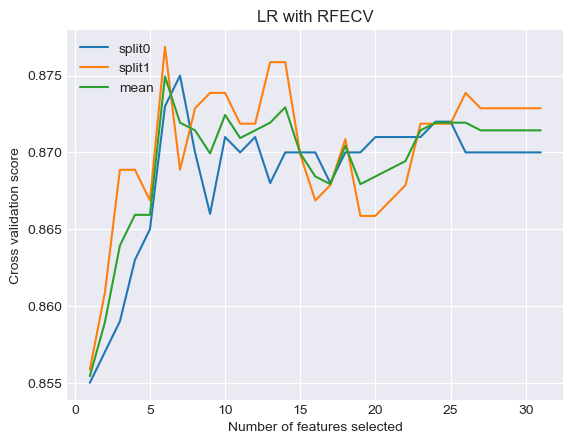

In [983]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

name = 'LR'  # use any LR, DT
model = models[name]

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring="accuracy")
rfecv.fit(X_train, y_train)
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f"{name} with RFECV")
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
results = rfecv.cv_results_
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split0_test_score'], label='split0')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['split1_test_score'], label='split1')
plt.plot(range(1, len(results['mean_test_score']) + 1), results['mean_test_score'], label='mean')
plt.legend()
plt.show()

In [984]:
len(rfecv.support_), len(features)

(31, 31)

In [985]:
# list of features selected
if len(rfecv.support_)<len(features):
    print("It looks like you have run cells out of order. Runn cells from Pre-Processing Data (2)")

features_selected = np.array(features)[rfecv.support_].tolist()
features_selected

['Intl_Plan',
 'VMail_Plan',
 'CustServ_Calls',
 'TotalCharges',
 'ComplainingCustomerWithAboveAverageCharges',
 'FixedIssue']

### Training - After Feature Selection

In [986]:
display(df.loc[:, features_selected + [target]].head(1))

# normalise 
X_train = scaler.fit_transform(df_train.loc[:,features_selected].values)
y_train = df_train.Churn.values
X_test = scaler.transform(df_test.loc[:,features_selected].values)
y_test = df_test.Churn.values

train_models()

,Intl_Plan,VMail_Plan,CustServ_Calls,TotalCharges,ComplainingCustomerWithAboveAverageCharges,FixedIssue,Churn
0,0,1,1,75.56,True,True,0



Model LR
	CV scores: 0.89, 0.88, 0.89, 0.83, 0.85, 0.88, 0.87, 0.84, 0.88, 0.86
	mean=86.74% std=0.0172

Model DT
	CV scores: 0.91, 0.92, 0.93, 0.93, 0.93, 0.92, 0.89, 0.92, 0.92, 0.91
	mean=91.55% std=0.0111

Model DT(max_depth=3)
	CV scores: 0.96, 0.96, 0.94, 0.93, 0.96, 0.95, 0.93, 0.96, 0.94, 0.93
	mean=94.75% std=0.0123

Model KNN
	CV scores: 0.94, 0.94, 0.93, 0.93, 0.94, 0.93, 0.91, 0.94, 0.94, 0.90
	mean=92.95% std=0.0141

Model SVC
	CV scores: 0.95, 0.94, 0.94, 0.91, 0.92, 0.94, 0.91, 0.91, 0.94, 0.88
	mean=92.34% std=0.0211

Best Performing Model DT(max_depth=3) with (mean CV of) accuracy = 94.75%


## Submit

 * Creates zip file to upload of notebooks in project

In [987]:
import glob
from zipfile import ZipFile

archive = f'{ROOT}/US_Churn_-_Feature_Engineering.zip'

if COLAB:
    files_to_upload = list(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/US_Churn*.ipynb"))
else: 
    files_to_upload = list(glob.glob("US_Churn*.ipynb"))
print(f"Creating zip archive with notbooks {files_to_upload} ...")

with ZipFile(archive,'w') as zip:
    for file in files_to_upload:
        basename = file.split("/Colab Notebooks/")[-1]
        zip.write(file, basename)

Creating zip archive with notbooks ['US_Churn-01-Import.ipynb', 'US_Churn-02-EDA.ipynb', 'US_Churn-03-Baseline_Model.ipynb', 'US_Churn-04-Feature_Engineering.ipynb'] ...
